<a href="https://colab.research.google.com/github/AdityaKumbhar21/Machine_Learning/blob/main/ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = (15, 6)
from datetime import datetime

In [7]:
def dateparse(dates):
  return datetime.strptime(dates,"%Y-%m")


df = pd.read_csv('/content/AirPassengers_demo.csv', parse_dates=['Month'], index_col='Month', date_parser=dateparse)

/tmp/ipython-input-7-558673676.py:5: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv('/content/AirPassengers_demo.csv', parse_dates=['Month'], index_col='Month', date_parser=dateparse)


In [10]:
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [11]:
ts = df['#Passengers']
ts.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [12]:
ts['1949-01-01']

np.int64(112)

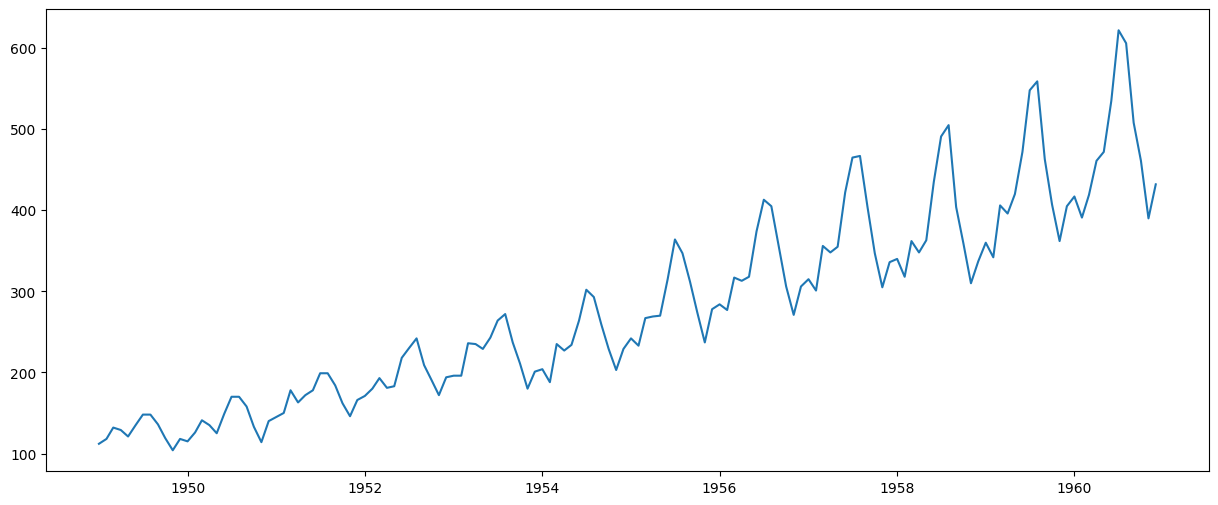

In [13]:
plt.plot(ts)

### Stationary Test

In [26]:
from statsmodels.tsa.stattools import adfuller
# dickey-fuller test

def stationary_test(timeseries):
  print("Results of Dickey Fuller test: ")
  dftest = adfuller(timeseries, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

  for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

  print(dfoutput)

In [27]:
stationary_test(ts)

Results of Dickey Fuller test: 
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


As the p value is > 0.05 so the data is not stationary

As the data is not stationary so we need to do Tranformation:  
- Log
- Double Log
- Difference

In [28]:
ts_log = np.log(ts)

In [29]:
stationary_test(ts_log)

Results of Dickey Fuller test: 
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


Still the data is not stationary

In [30]:
ts_dlog = np.log(ts_log)

In [31]:
stationary_test(ts_dlog)

Results of Dickey Fuller test: 
Test Statistic                  -2.156028
p-value                          0.222590
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


trying one more log if data is getting stationary or not

In [32]:
ts_tlog = np.log(ts_dlog)

In [33]:
stationary_test(ts_tlog)

Results of Dickey Fuller test: 
Test Statistic                  -2.391668
p-value                          0.144102
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


Trying Diff technique

In [38]:
ts_diff = ts.diff()
ts_diff.dropna(how='any', inplace=True)

In [39]:
stationary_test(ts_diff)

Results of Dickey Fuller test: 
Test Statistic                  -2.829267
p-value                          0.054213
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


As the we are close combining the log and diff.

In [48]:
ts_diff.isna().sum()

np.int64(0)

In [61]:
ts_logdiff = ts_log.diff()


In [62]:
ts_logdiff.dropna(how='any', inplace=True)

In [63]:
stationary_test(ts_logdiff)

Results of Dickey Fuller test: 
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


Still we are not able to get to the stationary level

Moving average Technique

In [64]:
rolling_mean = ts.rolling(window=12).mean()


ts_rolled = ts - rolling_mean


ts_rolled = ts_rolled.dropna()


In [65]:
stationary_test(ts_rolled)

Results of Dickey Fuller test: 
Test Statistic                  -3.164968
p-value                          0.022104
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


Now the data is stationary using the rolling average technique

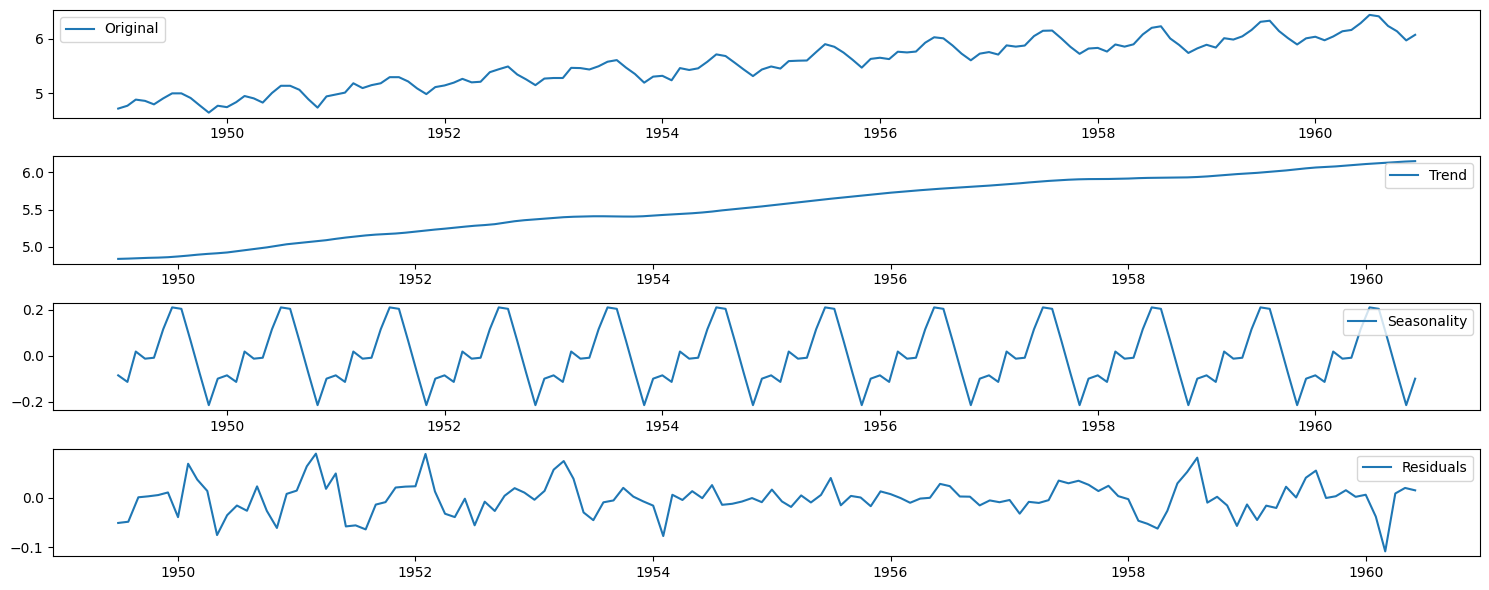

In [66]:
# splitting our ts data into original, trend , seasonaltity and residual with the help of seasonal_decompose()

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [72]:
# Train test split
ts_values = ts_log.values

split_idx = int(len(ts_values)*0.8)

train = ts_values[0:split_idx]
test = ts_values[split_idx:]

In [75]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [77]:
# Asuming values of (p,d,q) as (4,1,2)

history = [x for x in train]
predictions = []

for t in range(len(test)):
  try:
    model = ARIMA(history, order=(4,1,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
  except ValueError:
    pass
  print(f'Predicted: {yhat}, Expected: {obs}')

mse = mean_squared_error(test, predictions)
print("Mean Squared Error: ", mse)

from math import sqrt
rms = sqrt(mse)
print("Root Mean Squared Error: ", rms)


Predicted: 6.215272087982052, Expected: 6.22455842927536
Predicted: 6.257788050616063, Expected: 6.0014148779611505
Predicted: 5.890732599779219, Expected: 5.883322388488279
Predicted: 5.858094751241689, Expected: 5.736572297479192
Predicted: 5.699365386864289, Expected: 5.820082930352362
Predicted: 5.928238010168401, Expected: 5.886104031450156
Predicted: 5.904793266690148, Expected: 5.834810737062605
Predicted: 5.894913445836678, Expected: 6.0063531596017325
Predicted: 6.027457311229963, Expected: 5.981414211254481
Predicted: 5.954310043905425, Expected: 6.040254711277414
Predicted: 6.058647816650695, Expected: 6.156978985585555
Predicted: 6.096888074116561, Expected: 6.306275286948016
Predicted: 6.308209237670547, Expected: 6.326149473155099
Predicted: 6.228234165221378, Expected: 6.137727054086234
Predicted: 6.0548956322404655, Expected: 6.008813185442595
Predicted: 5.93925047710167, Expected: 5.8916442118257715
Predicted: 5.8781112241661075, Expected: 6.003887067106539
Predicted: 

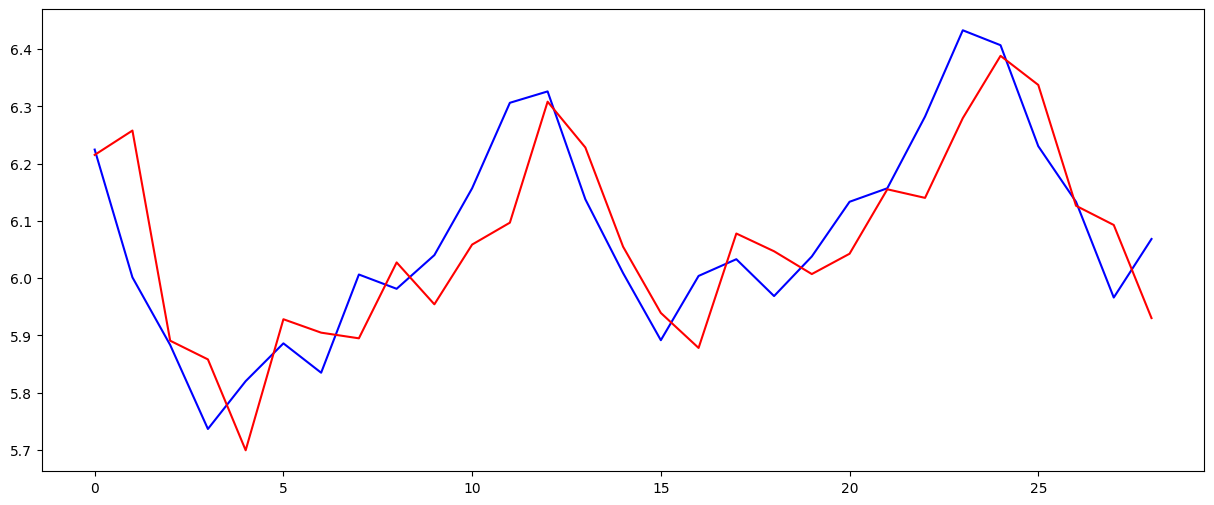

In [79]:
plt.plot(test, color = 'blue', label='test')
plt.plot(predictions, color='red', label='pred')
plt.show()

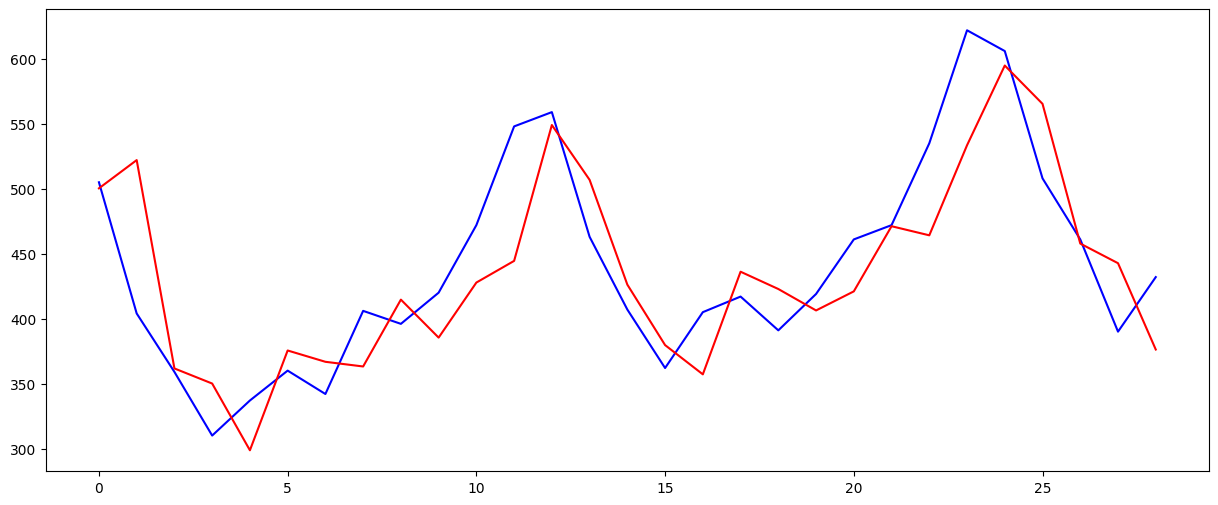

In [81]:
# plotting the org data -> inverse tranform
plt.plot(np.exp(test), color = 'blue', label='test')
plt.plot(np.exp(predictions), color='red', label='pred')
plt.show()


In [83]:
rms = sqrt(mean_squared_error(np.exp(test), np.exp(predictions)))
print('Root Mean Squarred Error: %.2f'% rms)


Root Mean Squarred Error: 47.07
